In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd

In [6]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

tweleve_months = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date > '2010-01-01').filter(Measurement.date < '2010-12-31').\
group_by(Measurement.date).all()

df_tweleve_months = pd.DataFrame(tweleve_months) #place info in df to make it easier to read

df_tweleve_months.head()


,date,prcp
0,2010-01-02,0.00
1,2010-01-03,0.00
2,2010-01-04,0.00
3,2010-01-05,0.00
4,2010-01-06,0.36


In [14]:
# Calculate the date 1 year ago from the last data point in the database
# 8/23/17 is the last date in the measurement table and there are 365 days in a year
# 1 year - 365 = date from a year ago

one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

print(one_year_ago)

2016-08-23


In [15]:
# Perform a query to retrieve the data and precipitation scores

date_precip_scores = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date > '2016-08-23').\
order_by(Measurement.date).all() #orders by all instances of measurement.date

#print(date_precip_scores) #prints all the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

df_date_precip_scores = pd.DataFrame(date_precip_scores)
df_date_precip_scores.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [16]:
# Sort the dataframe by date

date_sort = df_date_precip_scores.set_index('date') #set the index based on date

date_sort.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


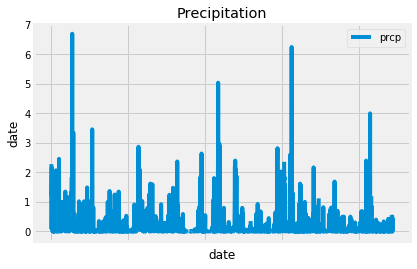

<Figure size 432x288 with 0 Axes>

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data

fig = date_sort.plot()
fig.set_title("Precipitation")
fig.set_ylabel('date')

plt.show()

plt.savefig("Precipitation.png")

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data

date_sort.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(Measurement.station).group_by(Measurement.station).count() #counts all the unique station id's in the station column

station_count


9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 

lowest_temp = session.query(Measurement.station, func.min(Measurement.tobs)).group_by(Measurement.station).first()
lowest_temp


('USC00511918', 53.0)

In [22]:
# highest temperature recorded

highest_temp = session.query(Measurement.station, func.max(Measurement.tobs)).group_by(Measurement.station).first()
highest_temp


('USC00511918', 87.0)

In [23]:
# most active station?

most_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).first()

most_active


('USC00519281', 2772)

In [24]:
# average temp of most active station

avg_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

avg_temp



[('USC00519281', 71.66378066378067)]

In [25]:
# Choose the station with the highest number of temperature observations.

temp_obs = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= '2016-08-23').\
order_by(Measurement.date.desc()).all()


temp_obs_df = pd.DataFrame(temp_obs)
temp_obs_df.head()


,tobs
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0


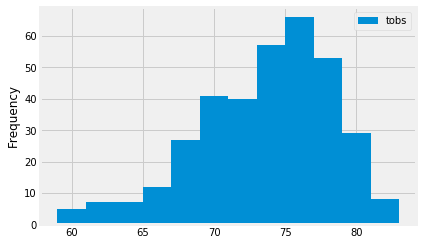

<Figure size 432x288 with 0 Axes>

In [26]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

plt.hist(temp_obs_df['tobs'], bins = 12)
plt.ylabel("Frequency")
plt.legend(["tobs"])

plt.show()

plt.savefig("12_Months_Temp.png")

In [35]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [38]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_results = calc_temps('2012-02-01', '2012-02-10')

trip_results


[(56.0, 66.85, 76.0)]

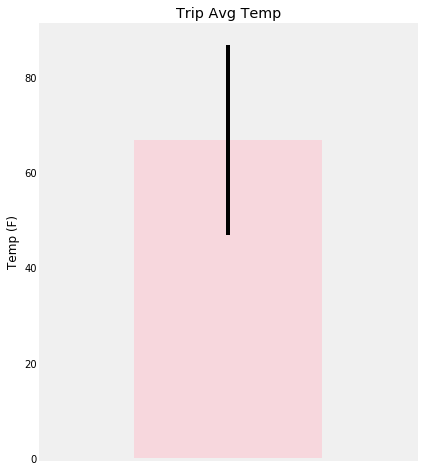

<Figure size 432x288 with 0 Axes>

In [39]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp']) #results in df with needed columns
avg_temp = trip_df['Avg Temp'] #holds the avg temp info

min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp'] #locks on tot he max and min temp
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='pink')

plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])

plt.grid()
plt.show()

plt.savefig("Trip_Avg_Temp.png")


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

prcp_station = session.query(Measurement.station, Station.name, func.sum(Measurement.prcp)).\
filter(Measurement.station == Station.station).filter(Measurement.date > '2012-02-28', Measurement.date < '2012-03-05').\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

prcp_station


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
